# This python notebook is to assist my program developing process and save useful images and discussion for the writeup.

### Import packages

In [1]:
# Import useful packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import signal
import cv2
import math
import sklearn
import csv
print('Pacakage imported')

Pacakage imported


### Load Driving_log data

In [2]:
# Set the driving_log.scv file path
csv_path = 'Driving_Data/driving_log.csv'

# Use panda to read the csv file
data_record = pd.read_csv(csv_path, #names=['center','left','right','steer','throttle','brake'],
                          index_col = False)
data_record['direction'] = pd.Series('s', index = data_record.index)

# Show the columns of the data sheet
print(data_record.shape)
test_data = data_record[0:5]


(7733, 8)


### Show the steer signal along frames in time sequence

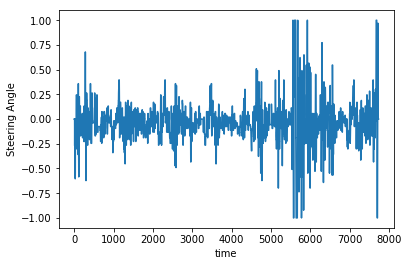

In [3]:
plot_len = 20000
data_steer = np.array(data_record.steering, dtype = np.float32)
time = np.arange(len(data_steer))
plt.plot(time[0:plot_len], data_steer[0:plot_len])
plt.xlabel('time')
plt.ylabel('Steering Angle')
# plt.ylim(-1,1)
# steer_sm = data_steer
# data_record['steer_sm'] = pd.Series(steer_sm, index=data_record.index)

### Show the speed log


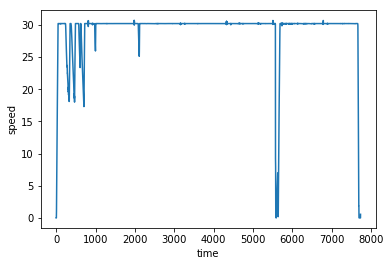

In [4]:
data_speed = np.array(data_record.speed, dtype = np.float32)
plt.plot(time[0:plot_len], data_speed[0:plot_len])
plt.xlabel('time')
plt.ylabel('speed')

## Image preprocess

In [5]:
# Define a image function loading and normalizing the input image
def image_new_norm(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = img/255.0 - 0.5
    return img

In [6]:
data_record.shape

(7733, 8)

### Image Augmentation 1: Including Left and Right images

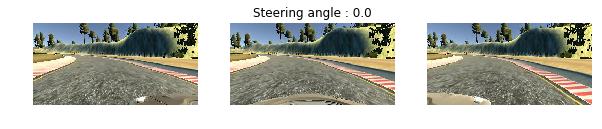

In [7]:
image_num = 16 # pick a random image
# print(data_record['center'][image_num].strip())

def path_editor(local_path):
    filename = local_path.split("\\")[-1]
    host_path = 'Driving_Data/IMG/'+filename
    # print(host_path)
    return host_path

image_center = image_new_norm(path_editor(data_record['center'][image_num].strip()))
image_left = image_new_norm(path_editor(data_record['left'][image_num].strip()))
image_right = image_new_norm(path_editor(data_record['right '][image_num].strip()))
plt.figure(figsize=(10, 6))
plt.subplot(1,3,1)
plt.imshow(image_left+.5);
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(image_center+.5);
plt.axis('off')
plt.title('Steering angle : '+ str(np.round(data_record['steering'][image_num]*25,2) ));
plt.subplot(1,3,3)
plt.imshow(image_right+.5);
plt.axis('off');

To use the left and right images, I shift the right  camera to the left by subtracting .25 and left camera to the right by adding .25. This shifting parameter is turned and tested in the training and validation step.

### Image Augmentation 2：Brightness augmentation

Thanks to the Vivek Yadav's post. I add this step to accomodate the model to both day and night driving environments, although it is not necessary to this project. I used the HSV scale and randomly adjusted the 'V' value by a scale from 0.2 to 1.2. The returning image is converted back to RGB.

In [8]:
def augment_brightness(image):
    imageHSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    random = 0.2 + np.random.uniform()
    imageHSV[:,:,2] = imageHSV[:,:,2] * random
    imageout = cv2.cvtColor(imageHSV, cv2.COLOR_HSV2RGB)
    return imageout

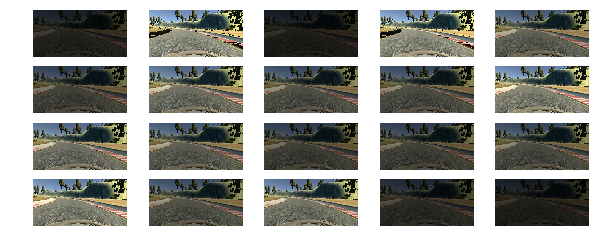

In [9]:
image2 = cv2.imread(path_editor(data_record['center'][image_num].strip()))
image2 = cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,5))
for i in range(20):
    image1 = augment_brightness(image2)
    plt.subplot(5,5,i+1)
    plt.imshow(image1)
    plt.axis('off')

### Augmentation 3: Shifting left/right and up/down
Processed images from this augmentation method simulate the effect of the car at different positions in the lane.

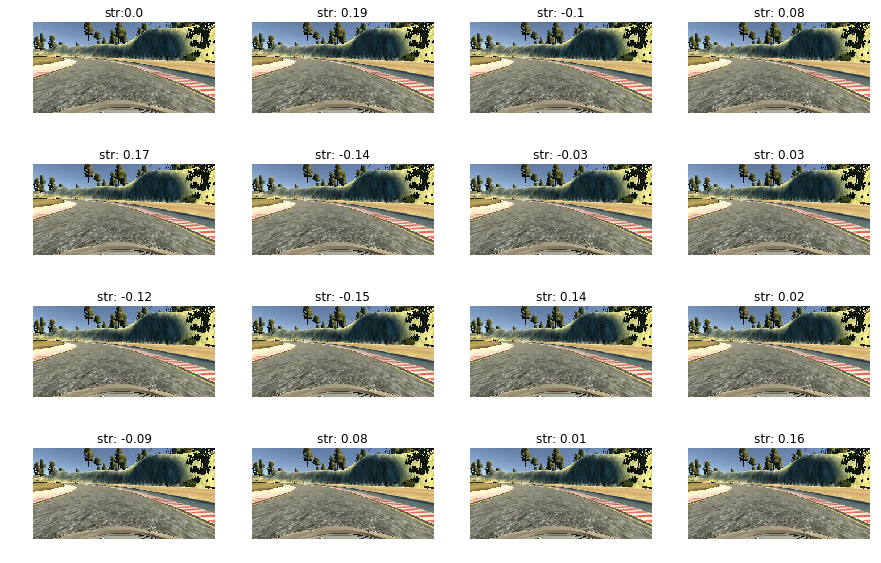

In [10]:
image = cv2.imread(path_editor(data_record['center'][image_num].strip()))
steer = data_steer[10]
image_l = cv2.imread(path_editor(data_record['left'][image_num].strip()))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_l = cv2.cvtColor(image_l, cv2.COLOR_BGR2RGB)

# Translate the image 
def trans_image(image, steer, trans_range):
    trans_x = trans_range * np.random.uniform() - trans_range/2 # To get positive and negative shift
    steer_ang = steer + trans_x / trans_range * 2 * 0.2
    trans_y = 10 * np.random.uniform() - 10/2
    Trans_m = np.float32([[1,0,trans_x],[0,1,trans_y]])
    image_trans = cv2.warpAffine(image, Trans_m, (image.shape[1], image.shape[0]))
    
    return image, steer_ang, trans_x
plt.figure(figsize = (15, 10))
plt.subplot(4,4,1)
plt.imshow(image)
plt.title('str:' + str(np.round(steer, 2)))
plt.axis('off')

for i in range(15):
    plt.subplot(4, 4, i+2)
    image_trans, steer_ang, trans_x = trans_image(image, steer, 80)
    plt.title('str: ' + str(np.round(steer_ang,2)))
    plt.imshow(image_trans)
    plt.axis('off');

### Augmentation 4: Flipping images
The output images from this augmentation method are flipped along the vertical axis to simulate the vehicle driving counterclockwise. The flipped images are chosen randomly. The corresponding steering angels are multiplied by -1 to make the vehicle steer to the opposite direction. Note, this augmentation is down using cv2.flip()

## Preprocessing

The following code is to show the examples of preprocessed images used as the input to the neural network. To further eliminate the unnecessary imformation and clean the image, I cropped the top 40% of the image and bottom 35 pixels for each image. The cropped image is reshaped to 128 x 128.

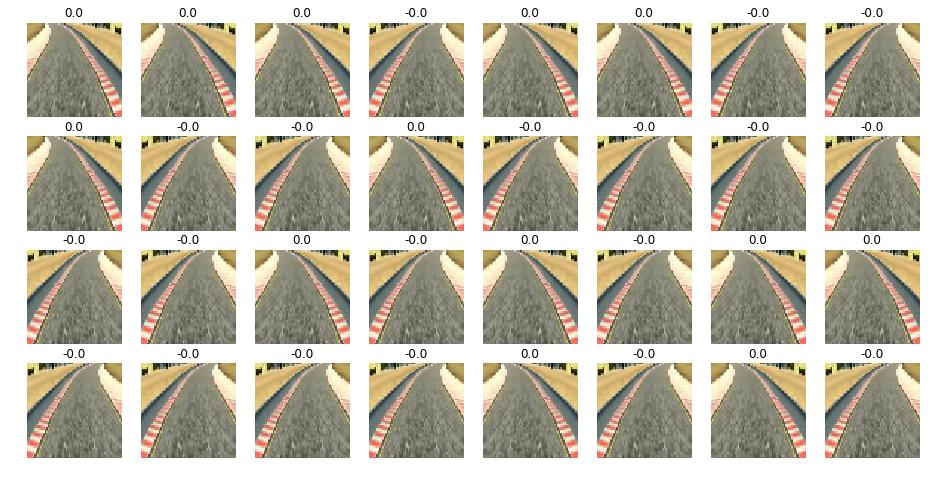

In [11]:
# Defint the size of the new image
new_image_col = 64
new_image_row = 64

def preprocessImage(image, new_image_row, new_image_col):
    image = image[math.floor(image.shape[0] * 0.4):(image.shape[0]-35), 0:image.shape[1]]
    image = cv2.resize(image,(new_image_row, new_image_col), interpolation = cv2.INTER_AREA)
    return image

def preprocess_image_train(image_path, steer, new_image_row, new_image_col):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    steer_out = steer
    # image, steer_out, trans_x = trans_image(image, steer, 150)
    # image = augment_brightness(image)
    image = preprocessImage(image, new_image_row, new_image_col)
    image = np.array(image)
    # Flip the image and inverse the steer angle
    flip_token = np.random.randint(2)
    if flip_token == 0:
        image = cv2.flip(image,1)
        steer_out = -steer_out
    return image, steer_out
def preprocess_image_predict(path, steer, new_image_row, new_image_col):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = preprocessImage(image, new_image_row, new_image_col)
    image = np.array(image)
    return image, steer

path_ex = path_editor(data_record['center'][10])
plt.figure(figsize=(16,8))
for i in range(32):
    image, steer = preprocess_image_train(path_ex, data_record['steering'][10],new_image_row, new_image_col)
    plt.subplot(4,8,i+1)
    plt.imshow(image);
    plt.axis('off')
    plt.title(str(np.round(steer,2)))
    
    

## Generator(Keras) and subsampling. The main pipeline and image preprocess

This set of training data does not have a bias toward going straight. If it is, I would like to drop the images with small angles.

In [12]:
samples = []
count=0
with open('./Driving_Data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    camera = ['center', 'left', 'right']
    for line in reader:
        # Disregard the tags in .csv file
        if line[0] == 'center':
            continue
        
        # Drop 80% of images whose steering angle is less than 0.3
        token = np.random.uniform()
        # token = 0.5
        if abs(float(line[3])) < 0.3:
            if token > 0.5:
                for i in range(3):
                    count += 1
                    samples.append([camera[i], line[i], line[3]])
            else:
                continue
        else:
            for i in range(3):
                count += 1
                samples.append([camera[i], line[i], line[3]])

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

from random import shuffle

### Show the image_steering profile after the droping process

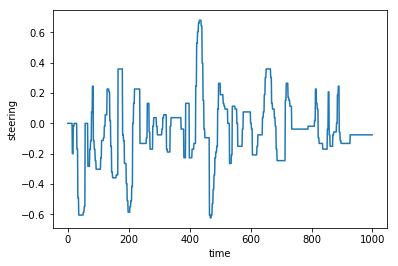

In [13]:
time = np.arange(len(samples))
samples_plot = np.array(samples)
plot_len = 1000
plt.plot(time[0:plot_len], samples_plot[0:plot_len, 2])
plt.xlabel('time')
plt.ylabel('steering')

In [14]:
def train_data_generator(samples, batch_size, new_image_row, new_image_col):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            angles = []
            for batch_sample in batch_samples:
                image_name = path_editor(batch_sample[1])
                steer_i = float(batch_sample[2])
                # Adjust the steer angle based on the camera position
                camera_pose = batch_sample[0]
                if camera_pose == 'center':
                    steer_ang = steer_i
                elif camera_pose == 'left':
                    steer_ang = steer_i + 0.25
                else:
                    steer_ang = steer_i - 0.25
                image, ang = preprocess_image_train(image_name, steer_ang, new_image_row, new_image_col)
                images.append(image)
                angles.append(ang)
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)
def valid_data_generator(samples, batch_size, new_image_row, new_image_col):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            
            images = []
            angles = []
            for batch_sample in batch_samples:
                image_name = path_editor(batch_sample[1])
                steer_i = float(batch_sample[2])
                # Adjust the steer angle based on the camera position
                camera_pose = batch_sample[0]
                if camera_pose == 'center':
                    steer_ang = steer_i
                elif camera_pose == 'left':
                    steer_ang = steer_i + 0.25
                else:
                    steer_ang = steer_i - 0.25
                image, ang = preprocess_image_predict(image_name, steer_ang, new_image_row, new_image_col)
                images.append(image)
                angles.append(ang)
            X_valid = np.array(images)
            y_valid = np.array(angles)
            yield sklearn.utils.shuffle(X_valid, y_valid)

## Model Architecture

### Fill some discription and attach a graph to explain the model architecture

In [15]:
import tensorflow as tf
# tf.python.control_flow_ops = tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Lambda
from keras.layers import Input, ELU
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras import initializers

Using TensorFlow backend.


In [16]:
new_size_row = 64
new_size_col = 64

input_shape = (new_size_row, new_size_col, 3)


filter_size = 3

pool_size = (2,2)
model = Sequential()
#model.add(MaxPooling2D(pool_size=pool_size,input_shape=input_shape))
model.add(Lambda(lambda x: x/255.0 - 0.5,input_shape=input_shape,output_shape=input_shape))

model.add(Conv2D(3, (1, 1), name="conv0",
       padding="valid", kernel_initializer="he_normal"))
model.add(ELU())

model.add(Conv2D(32, (filter_size, filter_size), name="conv1", 
                 padding="valid", kernel_initializer="he_normal"))
model.add(ELU())
model.add(Conv2D(32, (filter_size, filter_size), name="conv2", 
                 padding="valid", kernel_initializer="he_normal"))
model.add(ELU())
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.5))

model.add(Conv2D(64, (filter_size, filter_size), name="conv3", 
                 padding="valid", kernel_initializer="he_normal"))
model.add(ELU())

model.add(Conv2D(64, (filter_size, filter_size), name="conv4", 
                 padding="valid", kernel_initializer="he_normal"))
model.add(ELU())
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Dropout(0.5))


model.add(Conv2D(128, (filter_size, filter_size), name="conv5", 
                 padding="valid", kernel_initializer="he_normal"))
model.add(ELU())
model.add(Conv2D(128, (filter_size, filter_size), name="conv6", 
                 padding="valid", kernel_initializer="he_normal"))
model.add(ELU())
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.5))


model.add(Flatten())

model.add(Dense(512, name="hidden1", kernel_initializer="he_normal"))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Dense(64,name='hidden2', kernel_initializer="he_normal"))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Dense(16,name='hidden3',kernel_initializer="he_normal"))
model.add(ELU())
model.add(Dropout(0.5))
model.add(Dense(1, name='output', kernel_initializer="he_normal"))
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.99, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam,
          loss='mse')

## Training 

In [17]:
val_size = len(validation_samples)

batch_size = 256

i_best = 0
val_best = 1000
valid_generator = valid_data_generator(validation_samples, batch_size, new_size_col, new_size_row)
train_generator = train_data_generator(train_samples, batch_size, new_size_col, new_size_row)
model.fit_generator(train_generator, steps_per_epoch = np.round(len(train_samples)/batch_size), epochs=8, verbose=1, callbacks=None, validation_data=valid_generator,
                    validation_steps=np.round(val_size/batch_size), class_weight=None, workers=1, initial_epoch=0)
model.save('Model.h5')
print('The training is finished. Good Luck')

Epoch 1/8
39/39 [==============================] - 139s - loss: 5.6084 - val_loss: 0.4692
Epoch 2/8
39/39 [==============================] - 136s - loss: 2.1706 - val_loss: 0.2570
Epoch 3/8
39/39 [==============================] - 136s - loss: 1.8337 - val_loss: 0.3474
Epoch 4/8
39/39 [==============================] - 136s - loss: 1.6830 - val_loss: 0.4325
Epoch 5/8
39/39 [==============================] - 135s - loss: 1.4591 - val_loss: 0.2895
Epoch 6/8
39/39 [==============================] - 135s - loss: 1.3597 - val_loss: 0.1745
Epoch 7/8
39/39 [==============================] - 135s - loss: 1.2127 - val_loss: 0.2679
Epoch 8/8
39/39 [==============================] - 135s - loss: 1.1137 - val_loss: 0.1922
The training is finished. Good Luck
